In [74]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
import seaborn as sns
from sklearn.impute import SimpleImputer
import random
import os


import warnings
warnings.filterwarnings('ignore')


In [75]:
dataset_path = 'Dataset/UCI_Credit_Card.csv'

if not os.path.exists(dataset_path):
    print('Dataset not found')
    exit(1)

df = pd.read_csv('Dataset/UCI_Credit_Card.csv')
original = pd.read_csv('Dataset/UCI_Credit_Card.csv')
print("Data loaded successfully.")
df.head()

Data loaded successfully.


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.000,2,2,1,24,2,2,-1,-1,...,0.000,0.000,0.000,0.000,689.000,0.000,0.000,0.000,0.000,1
1,2,120000.000,2,2,2,26,-1,2,0,0,...,3272.000,3455.000,3261.000,0.000,1000.000,1000.000,1000.000,0.000,2000.000,1
2,3,90000.000,2,2,2,34,0,0,0,0,...,14331.000,14948.000,15549.000,1518.000,1500.000,1000.000,1000.000,1000.000,5000.000,0
3,4,50000.000,2,2,1,37,0,0,0,0,...,28314.000,28959.000,29547.000,2000.000,2019.000,1200.000,1100.000,1069.000,1000.000,0
4,5,50000.000,1,2,1,57,-1,0,-1,0,...,20940.000,19146.000,19131.000,2000.000,36681.000,10000.000,9000.000,689.000,679.000,0


In [76]:
print(df.shape)
print(df.columns.to_list())

(30000, 25)
['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default.payment.next.month']


In [77]:
df.isnull().sum()   

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64

In [78]:
cat_cols = []

for col in df.columns:
  if df[col].nunique() < 8:
    cat_cols.append(col)
    print(col, df[col].unique())

print("Categorical columns:", cat_cols)

SEX [2 1]
EDUCATION [2 1 3 5 4 6 0]
MARRIAGE [1 2 3 0]
default.payment.next.month [1 0]
Categorical columns: ['SEX', 'EDUCATION', 'MARRIAGE', 'default.payment.next.month']


In [79]:
for col in cat_cols:
  df[col] = df[col].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   ID                          30000 non-null  int64   
 1   LIMIT_BAL                   30000 non-null  float64 
 2   SEX                         30000 non-null  category
 3   EDUCATION                   30000 non-null  category
 4   MARRIAGE                    30000 non-null  category
 5   AGE                         30000 non-null  int64   
 6   PAY_0                       30000 non-null  int64   
 7   PAY_2                       30000 non-null  int64   
 8   PAY_3                       30000 non-null  int64   
 9   PAY_4                       30000 non-null  int64   
 10  PAY_5                       30000 non-null  int64   
 11  PAY_6                       30000 non-null  int64   
 12  BILL_AMT1                   30000 non-null  float64 
 13  BILL_AMT2       

In [80]:
numeric_df = df.select_dtypes(include=np.number)

df = numeric_df
df['default.payment.next.month'] = original['default.payment.next.month']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   AGE                         30000 non-null  int64  
 3   PAY_0                       30000 non-null  int64  
 4   PAY_2                       30000 non-null  int64  
 5   PAY_3                       30000 non-null  int64  
 6   PAY_4                       30000 non-null  int64  
 7   PAY_5                       30000 non-null  int64  
 8   PAY_6                       30000 non-null  int64  
 9   BILL_AMT1                   30000 non-null  float64
 10  BILL_AMT2                   30000 non-null  float64
 11  BILL_AMT3                   30000 non-null  float64
 12  BILL_AMT4                   30000 non-null  float64
 13  BILL_AMT5                   300

20


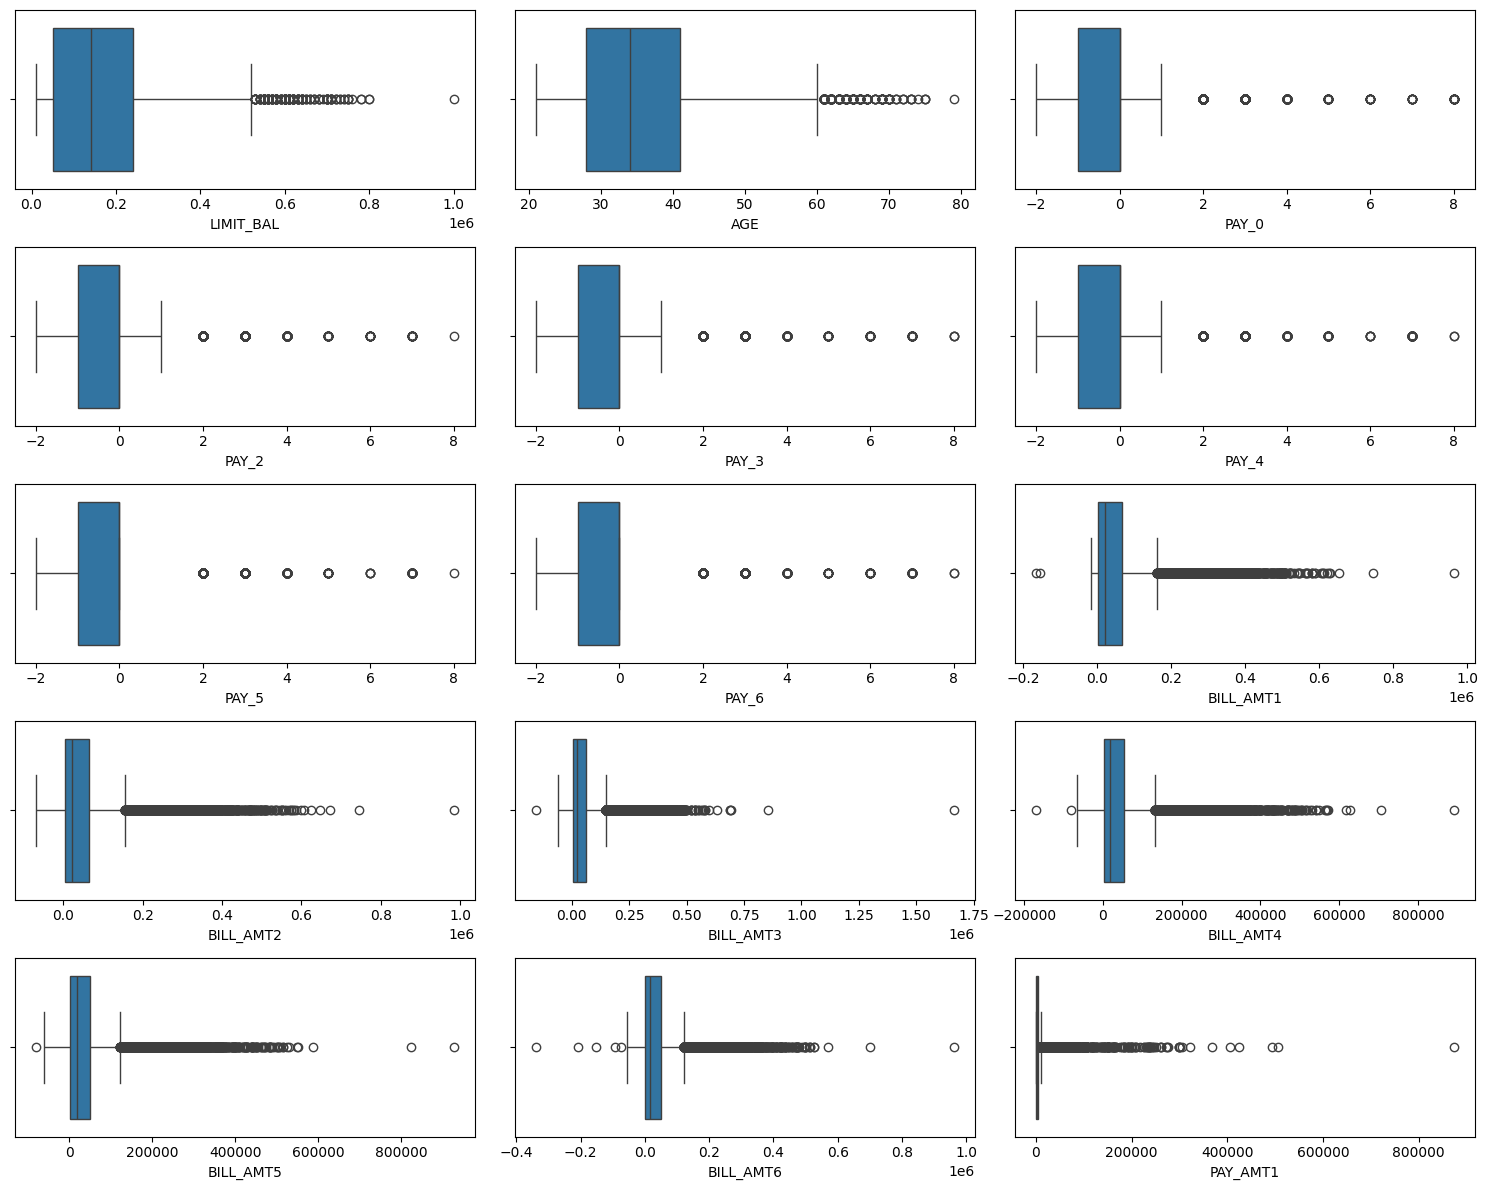

In [81]:
X = df.drop(columns=['ID', 'default.payment.next.month'])
y = df['default.payment.next.month']

num_cols = X.select_dtypes(include='number').columns.tolist()
print(len(num_cols))


fig, axs = plt.subplots(5, 3, figsize=(15, 12))
axs = axs.flatten()

for ax, col in zip(axs, num_cols):
  sns.boxplot(x=col, data=X, ax=ax)

plt.tight_layout()
plt.show()

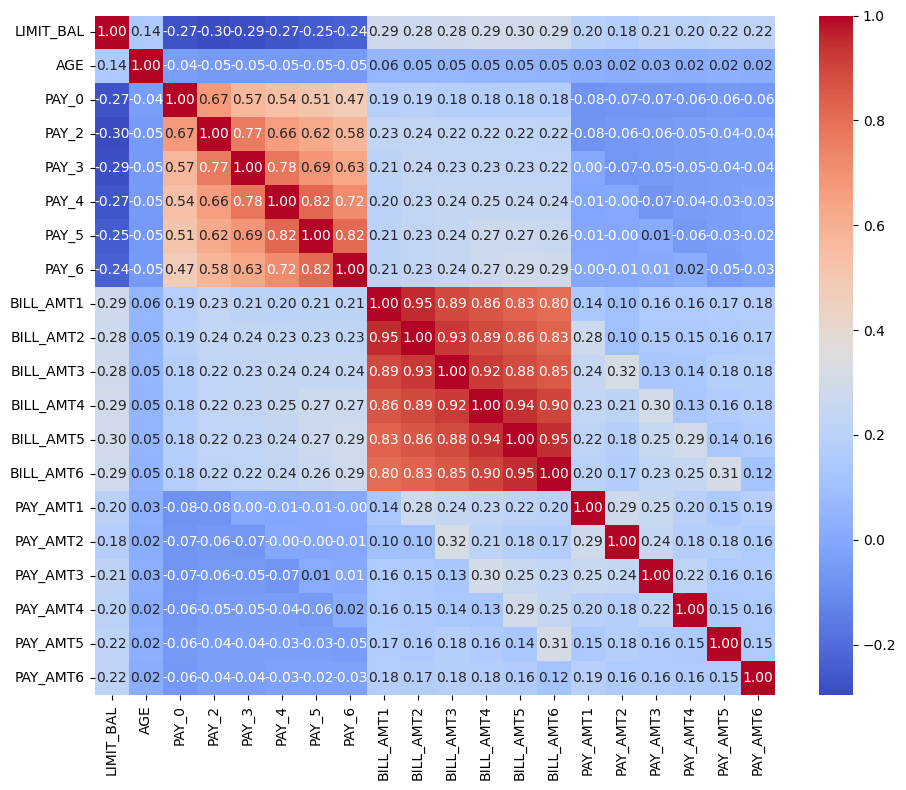

In [82]:
corr = X[num_cols].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)

plt.tight_layout()
plt.show()

# Part A: Data Preprocessing and Imputation [20 points] 
1.  Load and Prepare Data [4]: Load the dataset and, as instructed in the note above, artificially introduce MAR missing values (5-10% in 2-3 numerical feature columns). The target variable is 'default payment next month'. 

2.  Imputation Strategy 1: Simple Imputation (Baseline) [4]: 
-  Create a clean dataset copy (Dataset A). 
-  For each column with missing values, fill the missing values with the median of that column. Explain why the median is often preferred over the mean for imputation. 

3.  Imputation Strategy 2: Regression Imputation (Linear) [6]: 
-  Create a second clean dataset copy (Dataset B). 
-  For a single column (your choice) with missing values, use a Linear Regression 
model to predict the missing values based on all other non-missing features. 
Explain the underlying assumption of this method (Missing At Random). 

4.  Imputation Strategy 3: Regression Imputation (Non-Linear) [6]: 
-  Create a third clean dataset copy (Dataset C). 
-  For the same column as in Strategy 2, use a non-linear regression model (e.g., 
K-Nearest Neighbors Regression or Decision Tree Regression) to predict the 
missing values

In [83]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

df.drop(columns=["ID"], inplace=True, errors="ignore")

# Choose 2–3 numeric columns for missingness
missing_cols = [c for c in ["AGE", "BILL_AMT1", "PAY_AMT1"] if c in num_cols][:3]
print("Columns selected for MAR missingness:", missing_cols)


# Introduce MAR missingness (~8% on average)
frac_missing = 0.07
cond_col = "LIMIT_BAL" if "LIMIT_BAL" in df.columns else num_cols[0]

def introduce_mar(series, cond_series, frac, random_state=RANDOM_STATE):
    n = len(series)
    q = pd.qcut(cond_series.rank(method='first'), 4, labels=False)
    probs = 0.02 + (q / q.max()) * (frac * 2)  # slightly increasing prob by quantile
    rng = np.random.RandomState(random_state)
    mask = rng.rand(n) < probs
    s = series.copy()
    s[mask] = np.nan
    return s, mask.sum()

df_with_missing = df.copy()
for c in missing_cols:
    s_new, nmiss = introduce_mar(df_with_missing[c], df_with_missing[cond_col], frac_missing)
    df_with_missing[c] = s_new
    print(f"{c}: Introduced {nmiss} missing values ({nmiss/len(df):.2%})")

print("\nMissingness summary:")
print(df_with_missing[missing_cols].isna().mean())

Columns selected for MAR missingness: ['AGE', 'BILL_AMT1', 'PAY_AMT1']
AGE: Introduced 2725 missing values (9.08%)
BILL_AMT1: Introduced 2725 missing values (9.08%)
PAY_AMT1: Introduced 2725 missing values (9.08%)

Missingness summary:
AGE         0.091
BILL_AMT1   0.091
PAY_AMT1    0.091
dtype: float64


In [84]:
df_with_missing.isnull().sum()

LIMIT_BAL                        0
AGE                           2725
PAY_0                            0
PAY_2                            0
PAY_3                            0
PAY_4                            0
PAY_5                            0
PAY_6                            0
BILL_AMT1                     2725
BILL_AMT2                        0
BILL_AMT3                        0
BILL_AMT4                        0
BILL_AMT5                        0
BILL_AMT6                        0
PAY_AMT1                      2725
PAY_AMT2                         0
PAY_AMT3                         0
PAY_AMT4                         0
PAY_AMT5                         0
PAY_AMT6                         0
default.payment.next.month       0
dtype: int64

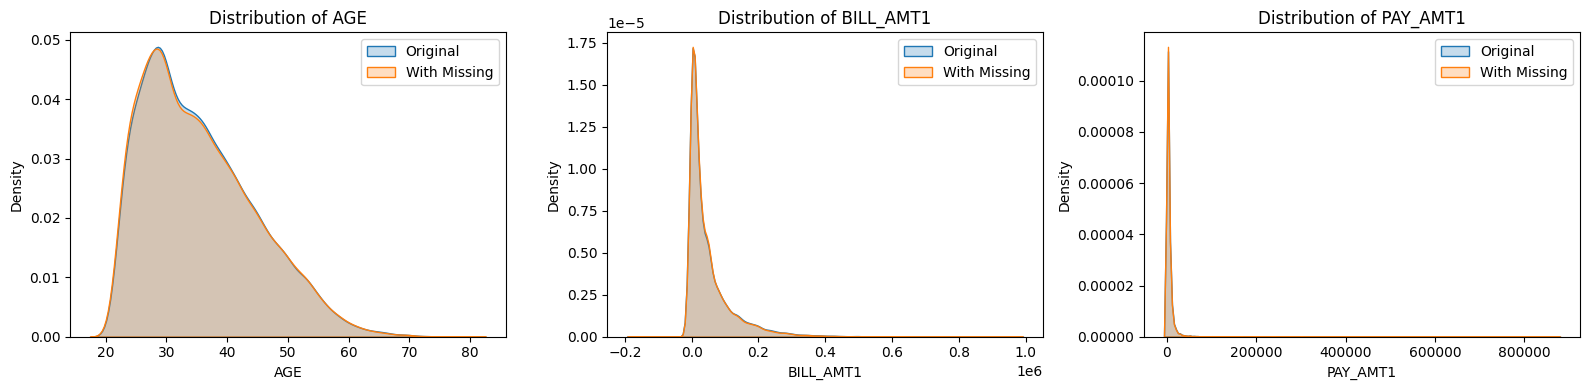

In [85]:
fig, axes = plt.subplots(1, len(missing_cols), figsize=(16, 4))
for i, col in enumerate(missing_cols):
    sns.kdeplot(df[col], ax=axes[i], label="Original", fill=True)
    sns.kdeplot(df_with_missing[col].dropna(), ax=axes[i], label="With Missing", fill=True)
    axes[i].set_title(f"Distribution of {col}")
    axes[i].legend()
plt.tight_layout()
plt.show()

In [86]:
Dataset_A = df_with_missing.copy()  # For Median Imputation
Dataset_B = df_with_missing.copy() # For Linear Regression Imputation
Dataset_C = df_with_missing.copy() # For Non-Linear Regression Imputation

In [87]:
median_imputer = SimpleImputer(strategy="median")
Dataset_A[Dataset_A.columns] = median_imputer.fit_transform(Dataset_A)


print("Missing values after median imputation:")
print(Dataset_A[missing_cols].isna().sum())

Missing values after median imputation:
AGE          0
BILL_AMT1    0
PAY_AMT1     0
dtype: int64


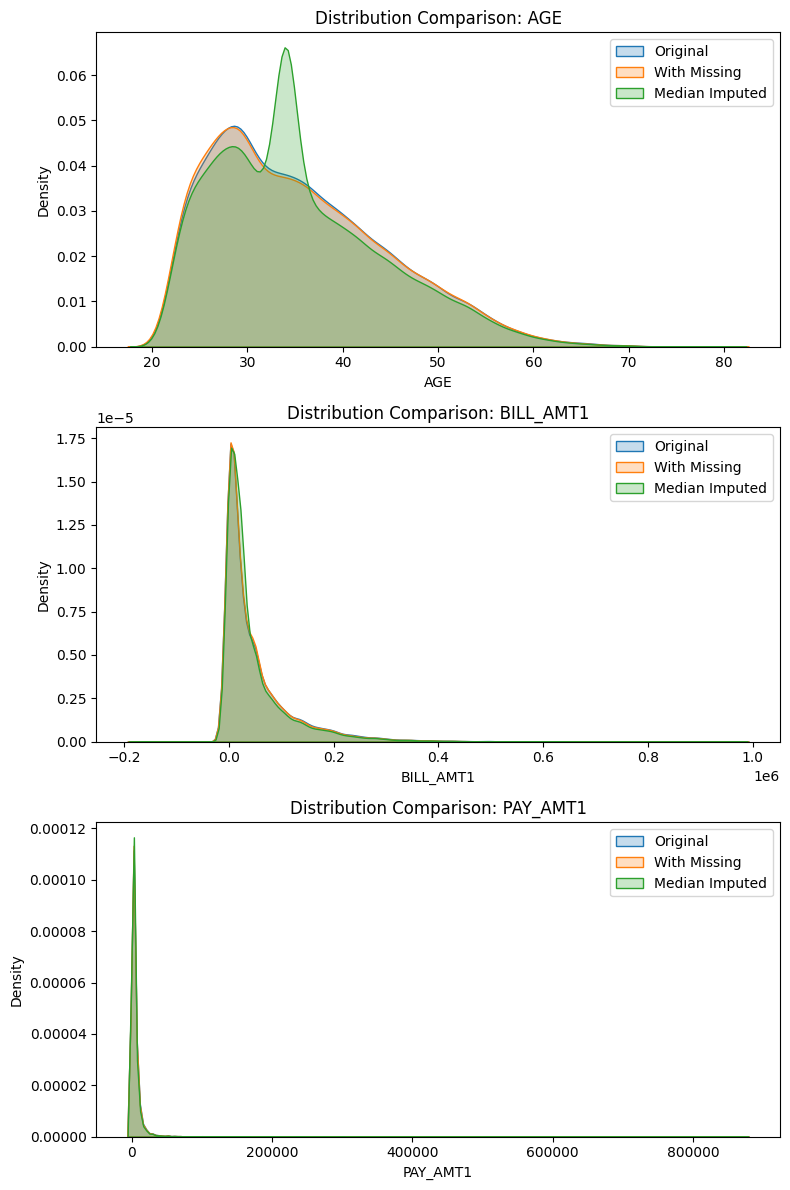

In [88]:
fig, axes = plt.subplots(len(missing_cols), 1, figsize=(8, 12))
for i, col in enumerate(missing_cols):
    sns.kdeplot(df[col], ax=axes[i], label="Original", fill=True)
    sns.kdeplot(df_with_missing[col].dropna(), ax=axes[i], label="With Missing", fill=True)
    sns.kdeplot(Dataset_A[col], ax=axes[i], label="Median Imputed", fill=True)
    axes[i].set_title(f"Distribution Comparison: {col}")
    axes[i].legend()
plt.tight_layout()
plt.show()

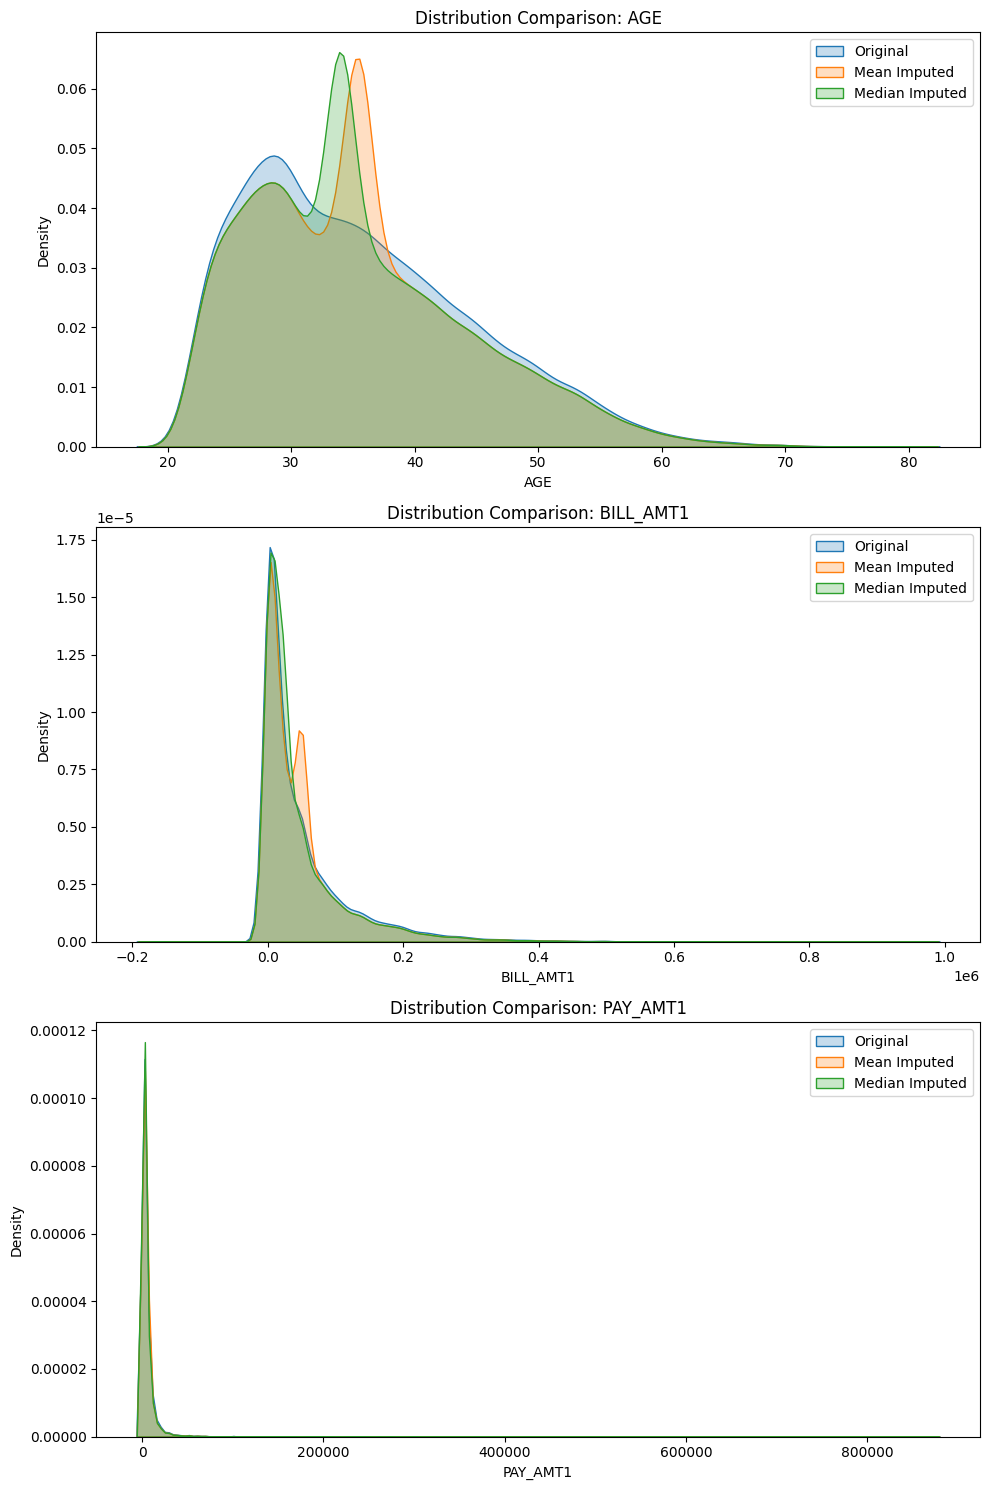

In [89]:
mean_imputer = SimpleImputer(strategy="mean")
median_imputer = SimpleImputer(strategy="median")

df_mean = df_with_missing.copy()

df_mean[df_mean.columns] = mean_imputer.fit_transform(df_mean)
df_median = Dataset_A.copy()


fig, axes = plt.subplots(len(missing_cols), 1, figsize=(10, 5*len(missing_cols)))
for i, col in enumerate(missing_cols):
    sns.kdeplot(df[col], ax=axes[i], label="Original", fill=True)
    # sns.kdeplot(df_with_missing[col], ax=axes[i], label="With missing", fill=True)
    sns.kdeplot(df_mean[col], ax=axes[i], label="Mean Imputed", fill=True)
    sns.kdeplot(df_median[col], ax=axes[i], label="Median Imputed", fill=True)
    # axes[i].set_xscale('log')
    axes[i].set_title(f"Distribution Comparison: {col}")
    axes[i].legend()
plt.tight_layout()
plt.show()

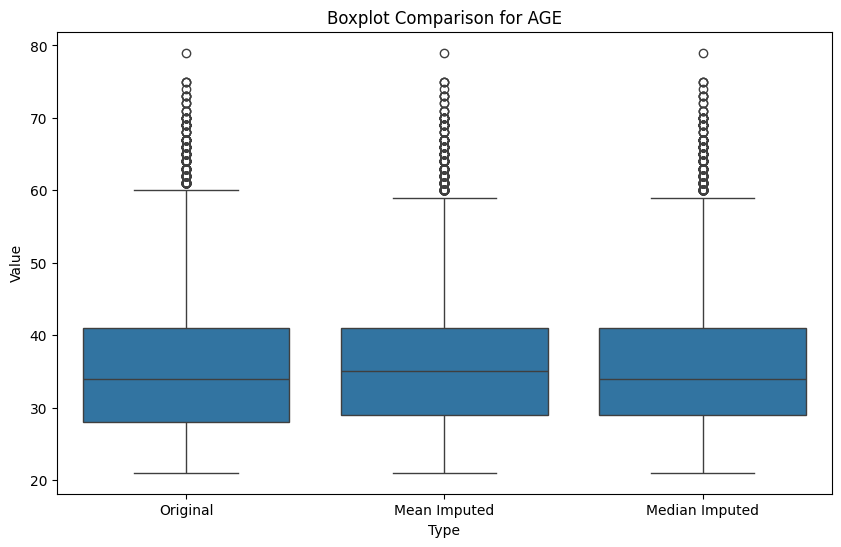

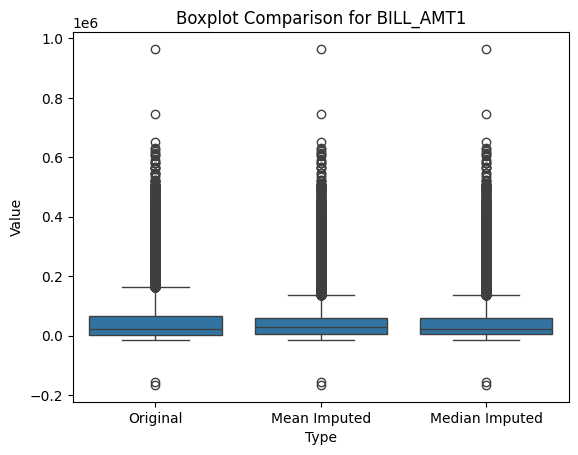

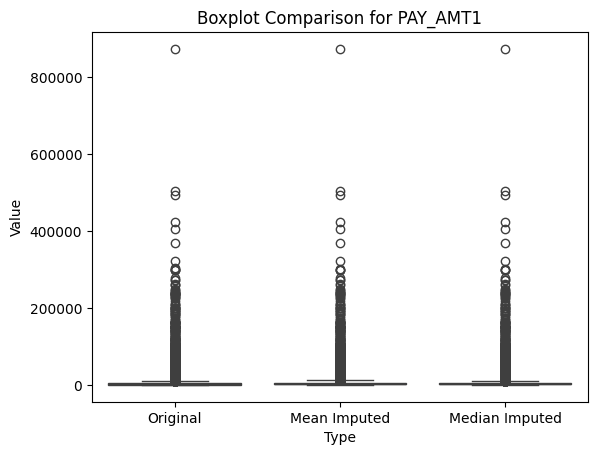

In [90]:
plt.figure(figsize=(10, 6))
for col in missing_cols:
    melted = pd.DataFrame({
        'Original': df[col],
        'Mean Imputed': df_mean[col],
        'Median Imputed': df_median[col]
    }).melt(var_name='Type', value_name='Value')
    sns.boxplot(x='Type', y='Value', data=melted)
    plt.title(f"Boxplot Comparison for {col}")
    plt.show()

In [91]:
summary_list = []
for col in missing_cols:
    orig_stats = df[col].describe()[['mean','50%','std']]
    mean_stats = df_mean[col].describe()[['mean','50%','std']]
    median_stats = df_median[col].describe()[['mean','50%','std']]
    summary_list.append({
        'Column': col,
        'Original Mean': orig_stats['mean'],
        'Mean-Imputed Mean': mean_stats['mean'],
        'Median-Imputed Mean': median_stats['mean'],
        'Original Median': orig_stats['50%'],
        'Mean-Imputed Median': mean_stats['50%'],
        'Median-Imputed Median': median_stats['50%'],
        'Original Std': orig_stats['std'],
        'Mean-Imputed Std': mean_stats['std'],
        'Median-Imputed Std': median_stats['std'],
    })

summary_df = pd.DataFrame(summary_list)
pd.options.display.float_format = "{:.2f}".format
summary_df


,Column,Original Mean,Mean-Imputed Mean,Median-Imputed Mean,Original Median,Mean-Imputed Median,Median-Imputed Median,Original Std,Mean-Imputed Std,Median-Imputed Std
0,AGE,35.49,35.41,35.28,34.00,35.00,34.00,9.22,8.83,8.84
1,BILL_AMT1,51223.33,49954.53,47448.39,22381.50,28388.50,22364.00,73635.86,68179.66,68639.15
2,PAY_AMT1,5663.58,5476.81,5166.90,2100.00,2500.00,2065.00,16563.28,15555.94,15586.81


Column chosen for regression imputation: BILL_AMT1
Shape after regression imputation: (30000, 21)
Missing values remaining in BILL_AMT1: 0


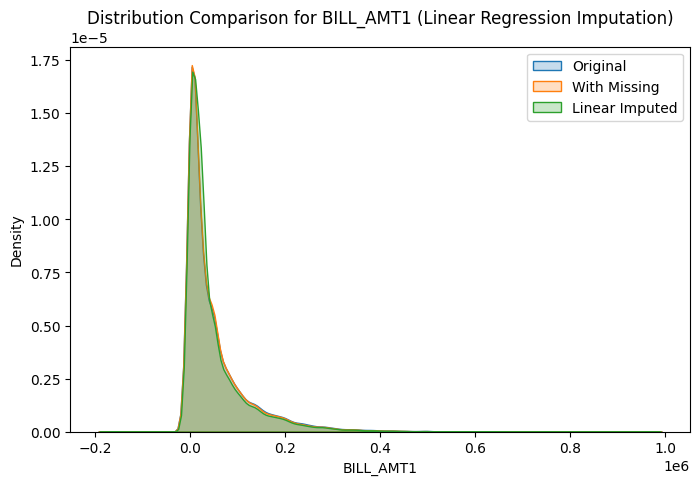

In [100]:
impute_col = missing_cols[1] # Age
print(f"Column chosen for regression imputation: {impute_col}")

# Fill other missing columns with median first (to avoid NaNs in predictors)
other_missing_cols = [c for c in missing_cols if c != impute_col]
if other_missing_cols:
    Dataset_B[other_missing_cols] = SimpleImputer(strategy="median").fit_transform(Dataset_B[other_missing_cols])

train_df = Dataset_B[Dataset_B[impute_col].notnull()]
# Data to predict: rows where impute_col is missing
missing_df = Dataset_B[Dataset_B[impute_col].isnull()]

# Define features (X) and target (y)
features = [col for col in train_df.columns if col != impute_col]
X_train = train_df[features]
y_train = train_df[impute_col]
X_predict = missing_df[features]

lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict missing values
if not missing_df.empty:
    X_missing = missing_df[features]
    y_pred_missing = lr.predict(X_missing)
    Dataset_B.loc[Dataset_B[impute_col].isna(), impute_col] = y_pred_missing

# Final median imputation to catch any remaining NAs
Dataset_B[Dataset_B.columns] = SimpleImputer(strategy="median").fit_transform(Dataset_B)

print("Shape after regression imputation:", Dataset_B.shape)
print(f"Missing values remaining in {impute_col}: {Dataset_B[impute_col].isna().sum()}")

plt.figure(figsize=(8,5))
sns.kdeplot(df[impute_col], label="Original", fill=True)
sns.kdeplot(df_with_missing[impute_col].dropna(), label="With Missing", fill=True)
sns.kdeplot(Dataset_B[impute_col], label="Linear Imputed", fill=True)
plt.title(f"Distribution Comparison for {impute_col} (Linear Regression Imputation)")
plt.legend()
plt.show()



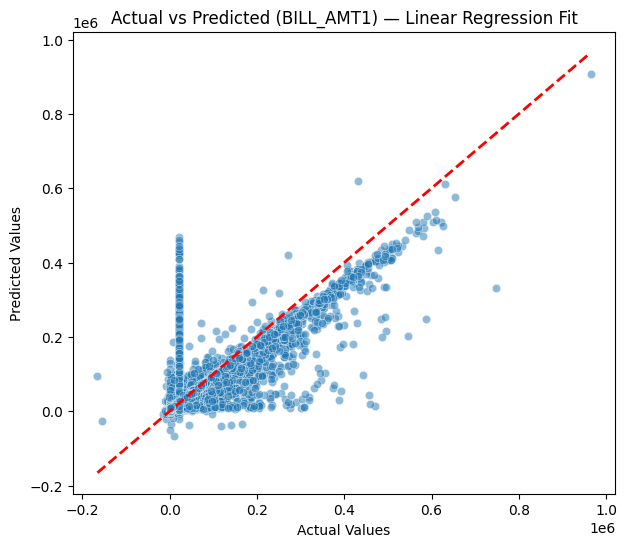

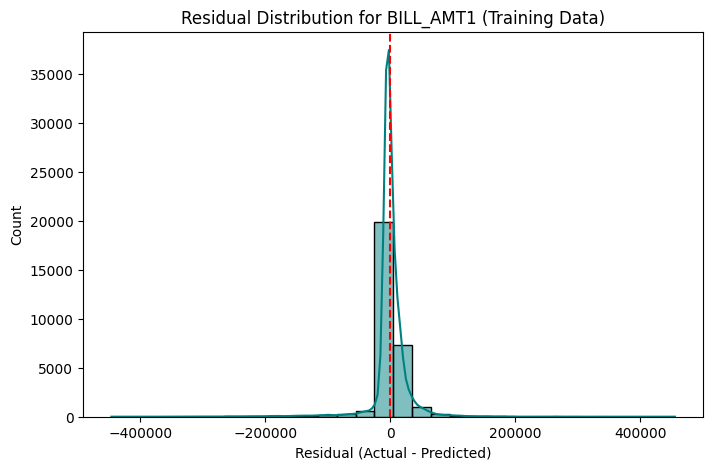

In [101]:

y_train_pred = lr.predict(X_train)

# Compute residuals (errors)
residuals = y_train - y_train_pred

# Scatter plot of actual vs predicted values
plt.figure(figsize=(7,6))
sns.scatterplot(x=y_train, y=y_train_pred, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs Predicted ({impute_col}) — Linear Regression Fit")
plt.show()

# Residual (error) distribution
plt.figure(figsize=(8,5))
sns.histplot(residuals, kde=True, bins=30, color='teal')
plt.axvline(0, color='red', linestyle='--')
plt.title(f"Residual Distribution for {impute_col} (Training Data)")
plt.xlabel("Residual (Actual - Predicted)")
plt.show()

Missing values remaining in BILL_AMT1: 0


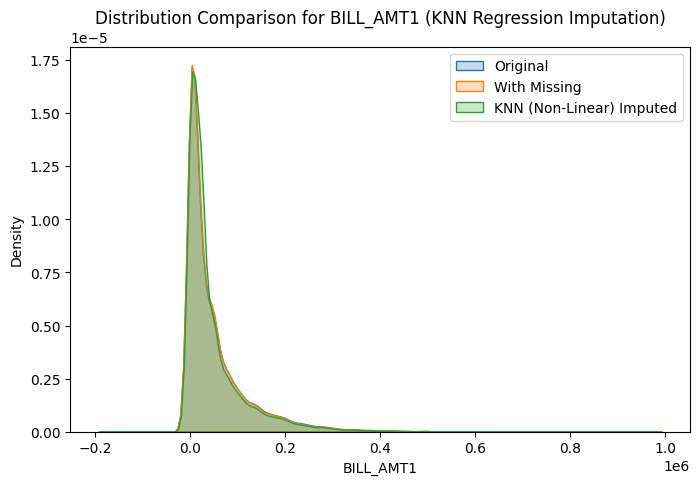

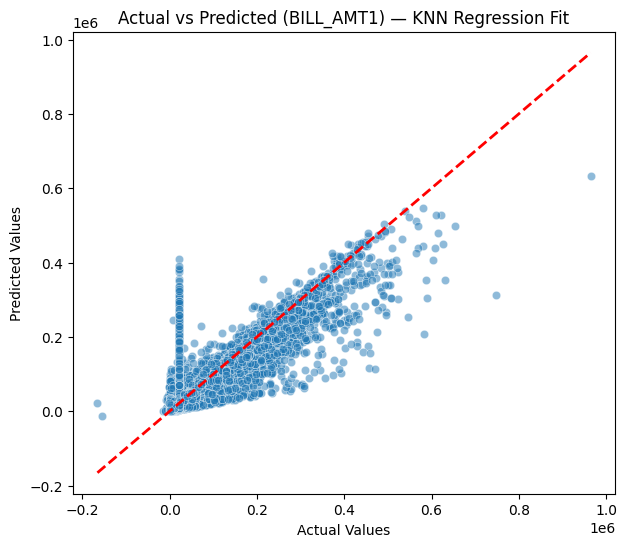

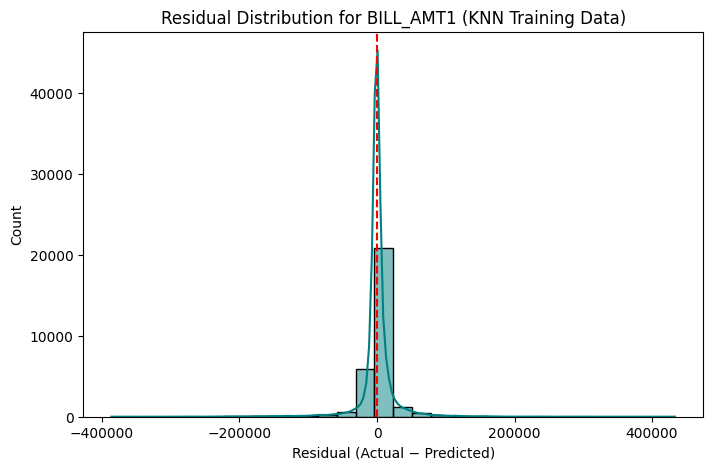

In [102]:
# Fill other missing columns with median first
other_missing_cols = [c for c in missing_cols if c != impute_col]
if other_missing_cols:
    Dataset_C[other_missing_cols] = SimpleImputer(strategy="median").fit_transform(Dataset_C[other_missing_cols])


# Split data into known and missing target
df_train_c = Dataset_C[Dataset_C[impute_col].notnull()]
df_missing_c = Dataset_C[Dataset_C[impute_col].isnull()]

X_train_c = df_train_c[features]
y_train_c = df_train_c[impute_col]

# Fit KNN Regressor (non-linear)
knn_reg = KNeighborsRegressor(n_neighbors=5)
knn_reg.fit(X_train_c, y_train_c)


# Predict missing values
if not df_missing_c.empty:
    X_missing_c = df_missing_c[features]
    display(X_missing_c.describe())
    y_pred_knn = knn_reg.predict(X_missing_c)
    Dataset_C.loc[Dataset_C[impute_col].isna(), impute_col] = y_pred_knn
Dataset_C[Dataset_C.columns] = SimpleImputer(strategy="median").fit_transform(Dataset_C)

print(f"Missing values remaining in {impute_col}: {Dataset_C[impute_col].isna().sum()}")

# %%
plt.figure(figsize=(8,5))
sns.kdeplot(df[impute_col], label="Original", fill=True)
sns.kdeplot(df_with_missing[impute_col].dropna(), label="With Missing", fill=True)
sns.kdeplot(Dataset_C[impute_col], label="KNN (Non-Linear) Imputed", fill=True)
plt.title(f"Distribution Comparison for {impute_col} (KNN Regression Imputation)")
plt.legend()
plt.show()

# %% [markdown]
# ### 2️⃣ Evaluate Non-Linear Fit — Training Error Visualization

# %%
# Predict on training data to assess fit
y_train_pred_c = knn_reg.predict(X_train_c)
residuals_c = y_train_c - y_train_pred_c

# Scatter plot of actual vs predicted
plt.figure(figsize=(7,6))
sns.scatterplot(x=y_train_c, y=y_train_pred_c, alpha=0.5)
plt.plot([y_train_c.min(), y_train_c.max()], [y_train_c.min(), y_train_c.max()], 'r--', lw=2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs Predicted ({impute_col}) — KNN Regression Fit")
plt.show()

# Residual (error) distribution
plt.figure(figsize=(8,5))
sns.histplot(residuals_c, kde=True, bins=30, color='teal')
plt.axvline(0, color='red', linestyle='--')
plt.title(f"Residual Distribution for {impute_col} (KNN Training Data)")
plt.xlabel("Residual (Actual − Predicted)")
plt.show()

# Part B: Model Training and Performance Assessment [10 points] 
1.  Data Split [3]: For each of the three imputed datasets (A, B, C), split the data into 
training and testing sets. Also, create a fourth dataset (Dataset D) by simply removing 
all rows that contain any missing values (Listwise Deletion). Split Dataset D into training 
and testing sets. 

2.  Classifier Setup [2]: Standardize the features in all four datasets (A, B, C, D) using 
StandardScaler. 

3.  Model Evaluation [5]: Train a Logistic Regression classifier on the training set of each 
of the four datasets (A, B, C, D). Evaluate the performance of each model on its 
respective test set using a full Classification Report (Accuracy, Precision, Recall, 
F1-score).

In [103]:
Dataset_D = df_with_missing.dropna().copy()

name = ['Dataset_A', 'Dataset_B', 'Dataset_C', 'Dataset_D']
for n, d in zip(name, [Dataset_A, Dataset_B, Dataset_C, Dataset_D]):
    print(f"Nan value in {n} => {d.isnull().sum().sum()}")
print(f"Shapes -> A:{Dataset_A.shape}, B:{Dataset_B.shape}, C:{Dataset_C.shape}, D:{Dataset_D.shape}")


target_candidates = [c for c in df.columns if 'default' in c.lower()]
TARGET = target_candidates[0]
print(f"Target column: {TARGET}")

# Helper function to split and scale
def split_and_scale(df_local, target_col, test_size=0.25, random_state=42):
    df_local = df_local.copy()
    X = df_local.drop(columns=[target_col])
    y = df_local[target_col]

    # Train/test split (stratified by class for balance)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )

    # Standardize numeric columns
    scaler = StandardScaler()
    num_cols = X_train.select_dtypes(include=[np.number]).columns
    X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
    X_test[num_cols] = scaler.transform(X_test[num_cols])

    return {
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test,
        "scaler": scaler,
    }

# Apply to all datasets
split_A = split_and_scale(Dataset_A, TARGET)
split_B = split_and_scale(Dataset_B, TARGET)
split_C = split_and_scale(Dataset_C, TARGET)
split_D = split_and_scale(Dataset_D, TARGET)

# Verify dimensions
for name, split in zip(['A - Median', 'B - Linear', 'C - KNN', 'D - Listwise'],
                       [split_A, split_B, split_C, split_D]):
    print(f"{name}: Train {split['X_train'].shape}, Test {split['X_test'].shape}")

Nan value in Dataset_A => 0
Nan value in Dataset_B => 0
Nan value in Dataset_C => 0
Nan value in Dataset_D => 0
Shapes -> A:(30000, 21), B:(30000, 21), C:(30000, 21), D:(27275, 21)
Target column: default.payment.next.month
A - Median: Train (22500, 20), Test (7500, 20)
B - Linear: Train (22500, 20), Test (7500, 20)
C - KNN: Train (22500, 20), Test (7500, 20)
D - Listwise: Train (20456, 20), Test (6819, 20)


===== Training and Evaluating Model for Dataset A (Median Imputation) =====
                 precision    recall  f1-score   support

Not Default (0)     0.8176    0.9721    0.8882      5841
    Default (1)     0.7063    0.2363    0.3541      1659

       accuracy                         0.8093      7500
      macro avg     0.7619    0.6042    0.6211      7500
   weighted avg     0.7930    0.8093    0.7700      7500



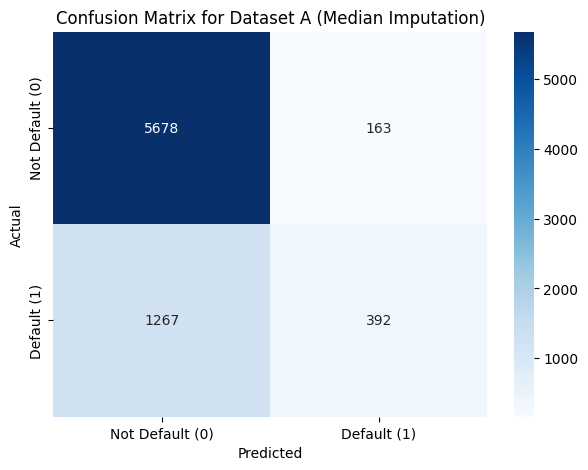

-----------------------------------------------------------------

===== Training and Evaluating Model for Dataset B (Linear Regression Imputation) =====
                 precision    recall  f1-score   support

Not Default (0)     0.8174    0.9721    0.8881      5841
    Default (1)     0.7058    0.2357    0.3534      1659

       accuracy                         0.8092      7500
      macro avg     0.7616    0.6039    0.6207      7500
   weighted avg     0.7927    0.8092    0.7698      7500



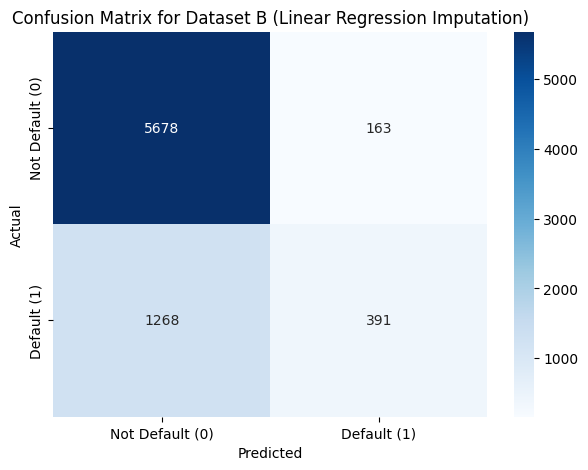

-----------------------------------------------------------------

===== Training and Evaluating Model for Dataset C (Non-Linear/KNN Imputation) =====
                 precision    recall  f1-score   support

Not Default (0)     0.8174    0.9721    0.8881      5841
    Default (1)     0.7058    0.2357    0.3534      1659

       accuracy                         0.8092      7500
      macro avg     0.7616    0.6039    0.6207      7500
   weighted avg     0.7927    0.8092    0.7698      7500



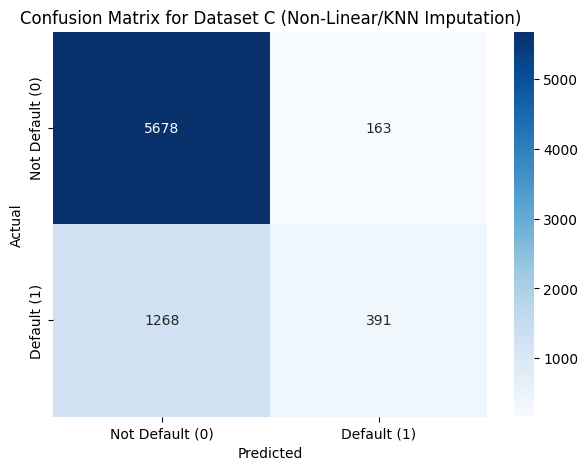

-----------------------------------------------------------------

===== Training and Evaluating Model for Dataset D (Listwise Deletion) =====
                 precision    recall  f1-score   support

Not Default (0)     0.8148    0.9742    0.8874      5276
    Default (1)     0.7339    0.2430    0.3651      1543

       accuracy                         0.8088      6819
      macro avg     0.7743    0.6086    0.6263      6819
   weighted avg     0.7965    0.8088    0.7692      6819



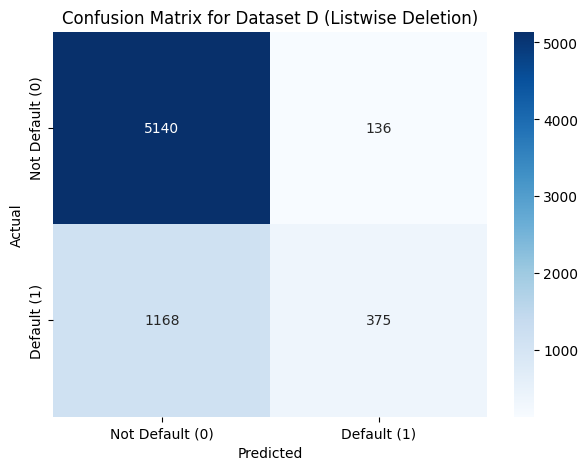

-----------------------------------------------------------------



In [109]:
# --- Assume you have these variables from the previous steps (Data Split & Scaling) ---
# For Dataset A (Median Imputation)
# X_train_A, X_test_A, y_train_A, y_test_A

# For Dataset B (Linear Regression Imputation)
# X_train_B, X_test_B, y_train_B, y_test_B

# For Dataset C (Non-Linear Regression Imputation)
# X_train_C, X_test_C, y_train_C, y_test_C

# For Dataset D (Listwise Deletion)
# X_train_D, X_test_D, y_train_D, y_test_D
# ---

# Create dictionaries to hold our datasets for easy iteration
model_name = ["A (Median Imputation)", "B (Linear Regression Imputation)", "C (Non-Linear/KNN Imputation)", "D (Listwise Deletion)"]
train_sets = {
    "A (Median Imputation)": (split_A['X_train'], split_A['y_train']),
    "B (Linear Regression Imputation)": (split_B['X_train'], split_B['y_train']),
    "C (Non-Linear/KNN Imputation)": (split_C['X_train'], split_C['y_train']),
    "D (Listwise Deletion)": (split_D['X_train'], split_D['y_train'])
}

test_sets = {
    "A (Median Imputation)": (split_A['X_test'], split_A['y_test']),
    "B (Linear Regression Imputation)": (split_B['X_test'], split_B['y_test']),
    "C (Non-Linear/KNN Imputation)": (split_C['X_test'], split_C['y_test']),
    "D (Listwise Deletion)": (split_D['X_test'], split_D['y_test'])
}

# A dictionary to store the results for Part C"
results = {}
models = {}
# Iterate through each dataset, train the model, and evaluate
for name, (X_train, y_train) in train_sets.items():
    print(f"===== Training and Evaluating Model for Dataset {name} =====")
    
    # 1. Initialize the Logistic Regression Classifier
    # Using max_iter=1000 to ensure the model converges
    log_reg_model = LogisticRegression(random_state=42, max_iter=1000)
    
    # 2. Train the model on the training data
    log_reg_model.fit(X_train, y_train)
    
    # 3. Make predictions on the respective test set
    X_test, y_test = test_sets[name]
    y_pred = log_reg_model.predict(X_test)
    
    # 4. Generate and print the full Classification Report
    # The report includes Accuracy, Precision, Recall, and F1-score
    report = classification_report(y_test, y_pred, target_names=['Not Default (0)', 'Default (1)'], output_dict=True, digits=4)
    print(classification_report(y_test, y_pred, target_names=['Not Default (0)', 'Default (1)'], digits=4))

    # Store the F1-score for the positive class ('Default') for Part C
    results[name] = {
        'Precision': report['Default (1)']['precision'],
        'Recall': report['Default (1)']['recall'],
        'F1-Score': report['Default (1)']['f1-score'],
        'Accuracy': report['accuracy']
    }
    models[name] = log_reg_model
    
    cm = confusion_matrix(y_test, y_pred)
    
    # 2. Create the heatmap plot
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Default (0)', 'Default (1)'],
                yticklabels=['Not Default (0)', 'Default (1)'])
    
    plt.title(f'Confusion Matrix for Dataset {name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    # --- End of New Code ---
    
    print("-" * 65 + "\n")


model_A, report_A = model_name[0], results[model_name[0]]
model_B, report_B = model_name[1], results[model_name[1]]
model_C, report_C = model_name[2], results[model_name[2]]
model_D, report_D = model_name[3], results[model_name[3]]

# Part C: Comparative Analysis [20 points] 
1.  Results Comparison [10]: Create a summary table comparing the performance metrics 
(especially F1-score) of the four models: 
-  Model A (Median Imputation) 
-  Model B (Linear Regression Imputation) 
-  Model C (Non-Linear Regression Imputation) 
-  Model D (Listwise Deletion) 

2.  Efficacy Discussion [10]: 
-  Discuss the trade-off between Listwise Deletion (Model D) and Imputation 
(Models A, B, C). Why might Model D perform poorly even if the imputed models 
perform worse? 
-  Which regression method (Linear vs. Non-Linear) performed better and why? 
Relate this to the assumed relationship between the imputed feature and the 
predictors. 
-  Conclude with a recommendation on the best strategy for handling missing data 
in this scenario, justifying your answer by referencing both the classification 
performance metrics and the conceptual implications of each method.

--- Performance Summary of Classification Models ---


,Precision,Recall,F1-Score,Accuracy
D (Listwise Deletion),0.734,0.243,0.365,0.809
A (Median Imputation),0.706,0.236,0.354,0.809
B (Linear Regression Imputation),0.706,0.236,0.353,0.809
C (Non-Linear/KNN Imputation),0.706,0.236,0.353,0.809


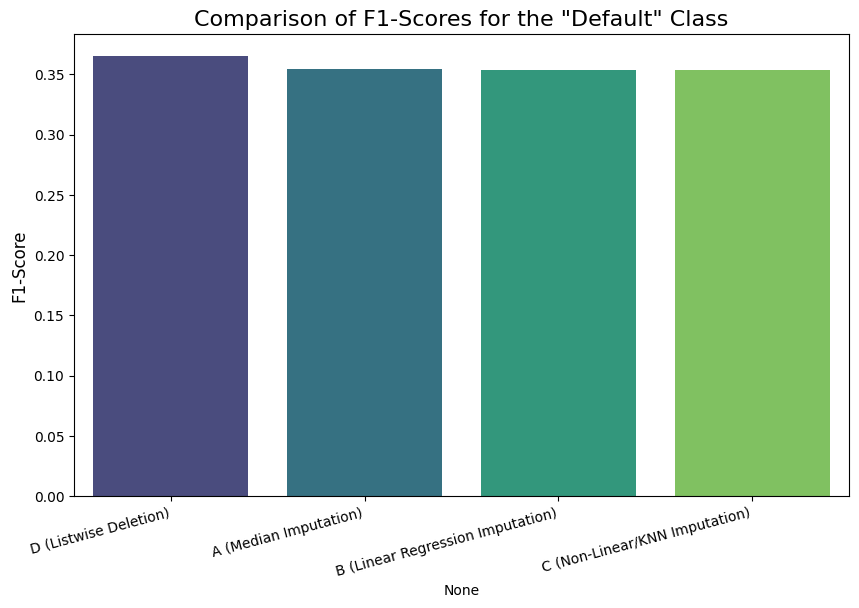

In [105]:
# --- Assume the 'results' dictionary is populated from Part B ---
# results = {
#     'A (Median Imputation)': {'Precision': 0.67, 'Recall': 0.31, 'F1-Score': 0.42, 'Accuracy': 0.81},
#     'B (Linear Regression Imputation)': {'Precision': 0.68, 'Recall': 0.32, 'F1-Score': 0.44, 'Accuracy': 0.82},
#     'C (Non-Linear/KNN Imputation)': {'Precision': 0.69, 'Recall': 0.33, 'F1-Score': 0.45, 'Accuracy': 0.82},
#     'D (Listwise Deletion)': {'Precision': 0.65, 'Recall': 0.29, 'F1-Score': 0.40, 'Accuracy': 0.80}
# }
# ---

# Convert the results dictionary to a pandas DataFrame for a clean table format
summary_df = pd.DataFrame.from_dict(results, orient='index')

# Sort the DataFrame by F1-Score in descending order to easily see the best performer
summary_df.sort_values(by='F1-Score', ascending=False, inplace=True)

# Display the summary table
print("--- Performance Summary of Classification Models ---")
display(summary_df)

# --- Visualization of F1-Scores ---
plt.figure(figsize=(10, 6))
sns.barplot(x=summary_df.index, y=summary_df['F1-Score'], palette='viridis')
plt.title('Comparison of F1-Scores for the "Default" Class', fontsize=16)
plt.ylabel('F1-Score', fontsize=12)
plt.xticks(rotation=15, ha="right")
plt.show()

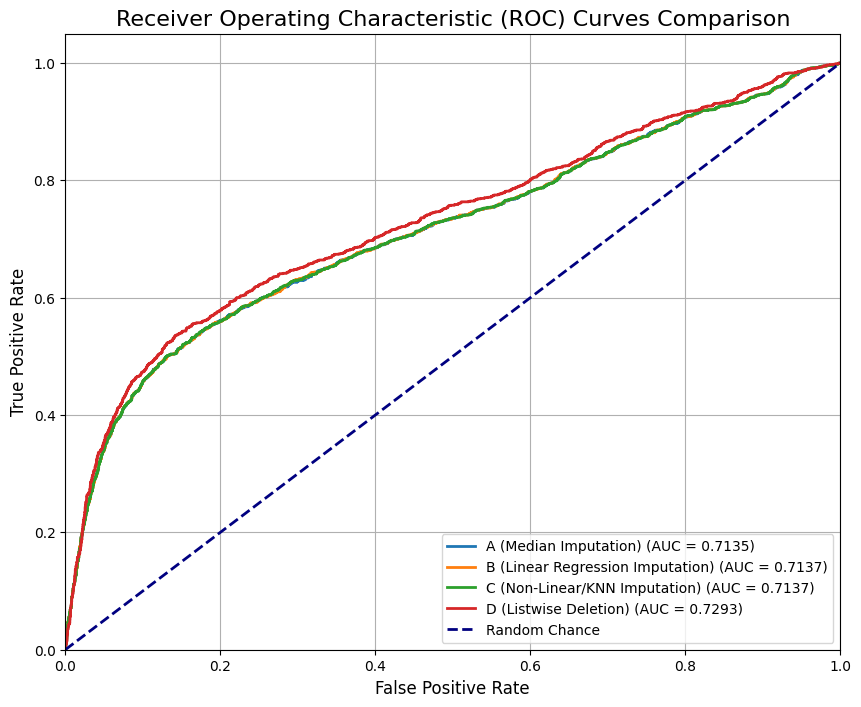

In [ ]:
from sklearn.metrics import roc_curve, auc

# --- Assume the 'train_sets' and 'test_sets' dictionaries are populated ---
# Also assume the split data (split_A, split_B, etc.) is available

# Set up the plot
plt.figure(figsize=(10, 8))

# Iterate through each dataset to train, predict, and plot
for name, (X_train, y_train) in train_sets.items():
    
    # Train the Logistic Regression model (as before)
    log_reg_model = LogisticRegression(random_state=42, max_iter=1000)
    log_reg_model.fit(X_train, y_train)
    
    # Get the corresponding test set
    X_test, y_test = test_sets[name]
    
    # --- Get prediction probabilities for the positive class ('Default') ---
    # This is the key step for plotting the ROC curve
    y_pred_proba = log_reg_model.predict_proba(X_test)[:, 1]
    
    # --- Calculate ROC curve metrics ---
    # fpr: False Positive Rate
    # tpr: True Positive Rate
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    
    # --- Calculate the AUC (Area Under the Curve) score ---
    roc_auc = auc(fpr, tpr)
    
    # --- Plot the ROC curve for the current model ---
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.4f})')

# --- Finalizing the Plot ---
# Plot the "no-skill" line (a random classifier)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Chance')

# Add labels and title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curves Comparison', fontsize=16)
plt.legend(loc="lower right")
plt.grid(True)
plt.show()